**Project Title : Language Translator**

Objective : Create a Language Translator using Python to convert German to English and vice-versa. 

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Reading the file through function given below:

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding="utf-8")
        
        # read all text
        text = file.read()
        file.close()
        return text

Splitting the text into sentences.

In [ ]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
data = read_text('/content/deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng=deu_eng[:50000,:]

Using first 50000 sentence pairs. 

In [ ]:
#Reviewing Data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there', 'Wer ist noch dort drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here', 'Wer war sonst noch hier drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window', 'Wer hat das Fenster hergerichtet',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['who else is in there', 'wer ist noch dort drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['who else was in here', 'wer war sonst noch hier drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['who fixed the window', 'wer hat das fenster hergerichtet',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

Capturing the lengths of all the sentences in two seperate lists for English and German

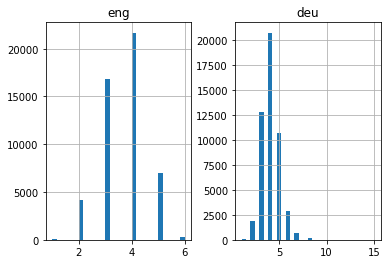

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()


The maximum length of German sentences is 11 and that of English phrases is 8.

Vectorizing text data using Keras' Tokenizer() class, turns our sentences into sequences of integers. Then, pad those sequences with zeroes to make all the sequences of same length. 

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6167


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10137


Function to prepare sequences:(will also perform sequence padding to a maximum setence length as mentioned above)

In [ ]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

Model Building

Split the data into train and set set for model training and evaluation, respectively. 

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Encoding the sentences. Encode German sentences as the input sequences and English sentences as the target sequences. To be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Defining Seq2Seq model:

Using Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [ ]:
#build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

Using RMSprop optimizer in the model because it usually is a good choice for recurrent neural networks.

In [ ]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


Used 'sparse_categorical_crossentropy' as the loss function because it allows us to target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.


Batch Size = 512

Using ModelCheckpoint() to save the best model with lowest validation loss. 

In [ ]:
filename = 'model.h1.24_vaidehi'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=4, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/4
63/63 [==============================] - 164s 3s/step - loss: 3.3614 - val_loss: 2.8217

Epoch 00001: val_loss improved from inf to 2.82173, saving model to model.h1.24_vaidehi


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


Epoch 2/4
63/63 [==============================] - 159s 3s/step - loss: 2.7002 - val_loss: 2.6916

Epoch 00002: val_loss improved from 2.82173 to 2.69163, saving model to model.h1.24_vaidehi


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


Epoch 3/4
63/63 [==============================] - 159s 3s/step - loss: 2.5286 - val_loss: 2.5224

Epoch 00003: val_loss improved from 2.69163 to 2.52236, saving model to model.h1.24_vaidehi


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


Epoch 4/4
63/63 [==============================] - 159s 3s/step - loss: 2.3700 - val_loss: 2.4129

Epoch 00004: val_loss improved from 2.52236 to 2.41293, saving model to model.h1.24_vaidehi


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


INFO:tensorflow:Assets written to: model.h1.24_vaidehi/assets


Comparing the training loss and validation loss.

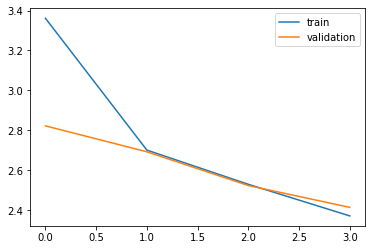

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Loading the saved model to make predictions. 

In [ ]:
model = load_model('model.h1.24_vaidehi')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if (index == n).all():
              return word
      return None

In [ ]:
#Convert Predictions into text
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pred_df.sample(20)

,actual,predicted
8708,tom is good at this,tom is a
6223,tom gave us the key,tom is a
1240,its breathtaking,its is
7597,do you think so,do you
7256,tom is recovering,tom is
2523,she is in the wrong,youre it
682,fill it up,its is
5759,i need friends,i have a
7497,she sat next to him,he was a
8543,tom loves doing this,tom is a
